## 样本迁移攻击

cuda


C:\Users\01\AppData\Local\Temp\ipykernel_10684\4014825140.py:46: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


Epsilon: 0.001	Attack progress: 200 / 1000	success:34
Epsilon: 0.001	Attack progress: 400 / 1000	success:61
Epsilon: 0.001	Attack progress: 600 / 1000	success:87
Epsilon: 0.001	Attack progress: 800 / 1000	success:125
Epsilon: 0.001	Attack success rate: 0.1524
Epsilon: 0.002	Attack progress: 200 / 1000	success:32
Epsilon: 0.002	Attack progress: 400 / 1000	success:59
Epsilon: 0.002	Attack progress: 600 / 1000	success:85
Epsilon: 0.002	Attack progress: 800 / 1000	success:123
Epsilon: 0.002	Attack success rate: 0.1503
Epsilon: 0.003	Attack progress: 200 / 1000	success:32
Epsilon: 0.003	Attack progress: 400 / 1000	success:59
Epsilon: 0.003	Attack progress: 600 / 1000	success:85
Epsilon: 0.003	Attack progress: 800 / 1000	success:124
Epsilon: 0.003	Attack success rate: 0.1513
Epsilon: 0.004	Attack progress: 200 / 1000	success:32
Epsilon: 0.004	Attack progress: 400 / 1000	success:59
Epsilon: 0.004	Attack progress: 600 / 1000	success:85
Epsilon: 0.004	Attack progress: 800 / 1000	success:124
Eps

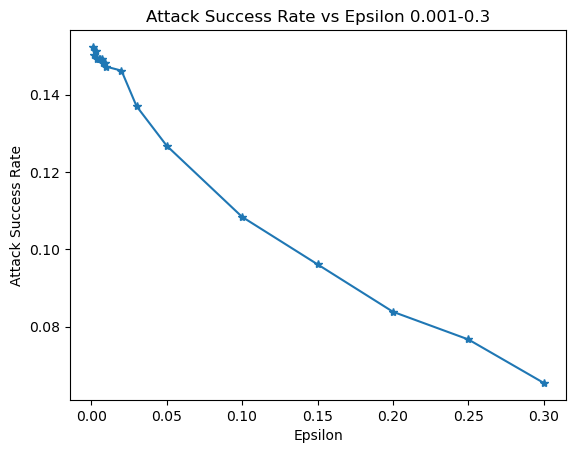

In [20]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

transform_test = transforms.Compose([
        # transforms.ToPILImage(),
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
with open('./attack_data/correct_1k.pkl', 'rb') as f:
    imgs, targets=pickle.load(f)
imgs = np.array(imgs) /255
targets = np.array(targets)
imgs = torch.from_numpy(imgs).view(1000, 1, 28, 28).float()
imgs = transform_test(imgs)
targets = torch.from_numpy(targets).view(1000).long()
test_data = torch.utils.data.TensorDataset(imgs, targets)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)


# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, target):
    if epsilon == 0:
            return False, perturbed_image
    perturbed_image = image
    attack_target = ((target + 1) % 10)
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        # perturbed_image.requires_grad = True
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, attack_target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image
        if perturbed_image.grad is None:
            return False, perturbed_image
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + epsilon * data_grad.sign()
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        if model(perturbed_image).max(1, keepdim=True)[1] == attack_target:
            return True, perturbed_image
    print('attack failed, hava reached max iteration')
    return False, perturbed_image

# 定义测试函数
def test(model, device, test_loader, epsilon):
    model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        # img = data.squeeze_(0).squeeze_(0)
        # plt.imshow(img, cmap='gray')
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        correct += 1

        success, perturbed_data = fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data, perturbed_data, target))
        # 打印进度信息
        if correct % 200 == 0:
            print(f"Epsilon: {epsilon}\tAttack progress: {correct} / {len(test_loader)}\tsuccess:{success_num}")
        if correct == 2000:
            break
    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epsilons = [.001, .002, .003, .004, .005, .006, .007, .008, .009, .01, .02, .03, .05, .10, .15, .2, .25, .3]
attack_accs = []
examples = []

# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('./checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('./attack_data/black'):
        os.makedirs('./attack_data/black')    
    torch.save(ex, f'./attack_data/black/eps-{eps:.3f}-ASR-{acc:.3f}.pt')

torch.save(examples, './attack_data/black/attack_examples.pt')

# plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate vs Epsilon 0.001-0.3")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()

```
Epsilon: 0.001	Attack progress: 200 / 1000	success:34
Epsilon: 0.001	Attack progress: 400 / 1000	success:61
Epsilon: 0.001	Attack progress: 600 / 1000	success:87
Epsilon: 0.001	Attack progress: 800 / 1000	success:125
Epsilon: 0.001	Attack success rate: 0.1524
Epsilon: 0.002	Attack progress: 200 / 1000	success:32
Epsilon: 0.002	Attack progress: 400 / 1000	success:59
Epsilon: 0.002	Attack progress: 600 / 1000	success:85
Epsilon: 0.002	Attack progress: 800 / 1000	success:123
Epsilon: 0.002	Attack success rate: 0.1503
Epsilon: 0.003	Attack progress: 200 / 1000	success:32
Epsilon: 0.003	Attack progress: 400 / 1000	success:59
Epsilon: 0.003	Attack progress: 600 / 1000	success:85
Epsilon: 0.003	Attack progress: 800 / 1000	success:124
Epsilon: 0.003	Attack success rate: 0.1513
Epsilon: 0.004	Attack progress: 200 / 1000	success:32
Epsilon: 0.004	Attack progress: 400 / 1000	success:59
Epsilon: 0.004	Attack progress: 600 / 1000	success:85
Epsilon: 0.004	Attack progress: 800 / 1000	success:124
Epsilon: 0.004	Attack success rate: 0.1493
Epsilon: 0.005	Attack progress: 200 / 1000	success:32
Epsilon: 0.005	Attack progress: 400 / 1000	success:59
Epsilon: 0.005	Attack progress: 600 / 1000	success:85
Epsilon: 0.005	Attack progress: 800 / 1000	success:124
Epsilon: 0.005	Attack success rate: 0.1493
Epsilon: 0.006	Attack progress: 200 / 1000	success:32
Epsilon: 0.006	Attack progress: 400 / 1000	success:59
Epsilon: 0.006	Attack progress: 600 / 1000	success:85
Epsilon: 0.006	Attack progress: 800 / 1000	success:124
Epsilon: 0.006	Attack success rate: 0.1493
Epsilon: 0.007	Attack progress: 200 / 1000	success:32
Epsilon: 0.007	Attack progress: 400 / 1000	success:59
Epsilon: 0.007	Attack progress: 600 / 1000	success:85
Epsilon: 0.007	Attack progress: 800 / 1000	success:124
Epsilon: 0.007	Attack success rate: 0.1493
Epsilon: 0.008	Attack progress: 200 / 1000	success:31
Epsilon: 0.008	Attack progress: 400 / 1000	success:58
Epsilon: 0.008	Attack progress: 600 / 1000	success:84
Epsilon: 0.008	Attack progress: 800 / 1000	success:123
Epsilon: 0.008	Attack success rate: 0.1483
Epsilon: 0.009	Attack progress: 200 / 1000	success:31
Epsilon: 0.009	Attack progress: 400 / 1000	success:58
Epsilon: 0.009	Attack progress: 600 / 1000	success:84
Epsilon: 0.009	Attack progress: 800 / 1000	success:123
Epsilon: 0.009	Attack success rate: 0.1483
Epsilon: 0.01	Attack progress: 200 / 1000	success:31
Epsilon: 0.01	Attack progress: 400 / 1000	success:58
Epsilon: 0.01	Attack progress: 600 / 1000	success:84
Epsilon: 0.01	Attack progress: 800 / 1000	success:122
Epsilon: 0.01	Attack success rate: 0.1472
Epsilon: 0.02	Attack progress: 200 / 1000	success:31
Epsilon: 0.02	Attack progress: 400 / 1000	success:58
Epsilon: 0.02	Attack progress: 600 / 1000	success:83
Epsilon: 0.02	Attack progress: 800 / 1000	success:121
Epsilon: 0.02	Attack success rate: 0.1462
Epsilon: 0.03	Attack progress: 200 / 1000	success:28
Epsilon: 0.03	Attack progress: 400 / 1000	success:53
Epsilon: 0.03	Attack progress: 600 / 1000	success:76
Epsilon: 0.03	Attack progress: 800 / 1000	success:112
Epsilon: 0.03	Attack success rate: 0.1370
Epsilon: 0.05	Attack progress: 200 / 1000	success:28
Epsilon: 0.05	Attack progress: 400 / 1000	success:53
Epsilon: 0.05	Attack progress: 600 / 1000	success:73
Epsilon: 0.05	Attack progress: 800 / 1000	success:102
Epsilon: 0.05	Attack success rate: 0.1268
Epsilon: 0.1	Attack progress: 200 / 1000	success:21
Epsilon: 0.1	Attack progress: 400 / 1000	success:43
Epsilon: 0.1	Attack progress: 600 / 1000	success:61
Epsilon: 0.1	Attack progress: 800 / 1000	success:88
Epsilon: 0.1	Attack success rate: 0.1084
Epsilon: 0.15	Attack progress: 200 / 1000	success:19
Epsilon: 0.15	Attack progress: 400 / 1000	success:40
Epsilon: 0.15	Attack progress: 600 / 1000	success:55
Epsilon: 0.15	Attack progress: 800 / 1000	success:78
Epsilon: 0.15	Attack success rate: 0.0961
Epsilon: 0.2	Attack progress: 200 / 1000	success:17
Epsilon: 0.2	Attack progress: 400 / 1000	success:35
Epsilon: 0.2	Attack progress: 600 / 1000	success:49
Epsilon: 0.2	Attack progress: 800 / 1000	success:69
Epsilon: 0.2	Attack success rate: 0.0838
Epsilon: 0.25	Attack progress: 200 / 1000	success:16
Epsilon: 0.25	Attack progress: 400 / 1000	success:32
Epsilon: 0.25	Attack progress: 600 / 1000	success:44
Epsilon: 0.25	Attack progress: 800 / 1000	success:64
Epsilon: 0.25	Attack success rate: 0.0767
Epsilon: 0.3	Attack progress: 200 / 1000	success:11
Epsilon: 0.3	Attack progress: 400 / 1000	success:25
Epsilon: 0.3	Attack progress: 600 / 1000	success:35
Epsilon: 0.3	Attack progress: 800 / 1000	success:53
Epsilon: 0.3	Attack success rate: 0.0654
```


cuda


C:\Users\01\AppData\Local\Temp\ipykernel_10684\834164845.py:46: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  if perturbed_image.grad is None:


Epsilon: 0.0001	Attack progress: 200 / 1000	success:34
Epsilon: 0.0001	Attack progress: 400 / 1000	success:61
Epsilon: 0.0001	Attack progress: 600 / 1000	success:87
Epsilon: 0.0001	Attack progress: 800 / 1000	success:125
Epsilon: 0.0001	Attack success rate: 0.1524
Epsilon: 0.00019999999999999998	Attack progress: 200 / 1000	success:34
Epsilon: 0.00019999999999999998	Attack progress: 400 / 1000	success:61
Epsilon: 0.00019999999999999998	Attack progress: 600 / 1000	success:87
Epsilon: 0.00019999999999999998	Attack progress: 800 / 1000	success:125
Epsilon: 0.00019999999999999998	Attack success rate: 0.1524
Epsilon: 0.0003	Attack progress: 200 / 1000	success:34
Epsilon: 0.0003	Attack progress: 400 / 1000	success:61
Epsilon: 0.0003	Attack progress: 600 / 1000	success:87
Epsilon: 0.0003	Attack progress: 800 / 1000	success:125
Epsilon: 0.0003	Attack success rate: 0.1524
Epsilon: 0.00039999999999999996	Attack progress: 200 / 1000	success:34
Epsilon: 0.00039999999999999996	Attack progress: 400 /

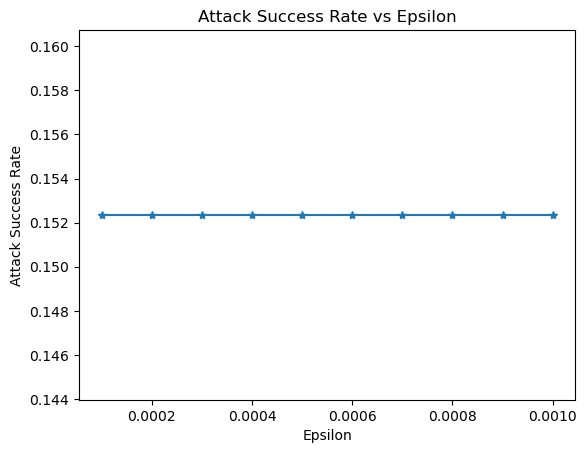

In [24]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

transform_test = transforms.Compose([
        # transforms.ToPILImage(),
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
with open('./attack_data/correct_1k.pkl', 'rb') as f:
    imgs, targets=pickle.load(f)
imgs = np.array(imgs) /255
targets = np.array(targets)
imgs = torch.from_numpy(imgs).view(1000, 1, 28, 28).float()
imgs = transform_test(imgs)
targets = torch.from_numpy(targets).view(1000).long()
test_data = torch.utils.data.TensorDataset(imgs, targets)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)


# 定义攻击函数
def fgsm_attack(image, epsilon, max_iter, model, target):
    if epsilon == 0:
            return False, perturbed_image
    perturbed_image = image
    attack_target = ((target + 1) % 10)
    # 迭代更新扰动值
    for i in range(max_iter):
        # 计算梯度并更新扰动值
        # perturbed_image.requires_grad = True
        perturbed_image.requires_grad_(True)
        output = model(perturbed_image)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, attack_target)
        model.zero_grad()
        loss.backward()
        # print(perturbed_image.grad.size())
        if epsilon == 0:
            return False, perturbed_image
        if perturbed_image.grad is None:
            return False, perturbed_image
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + epsilon * data_grad.sign()
        # 限制像素值范围在[0,1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        # 如果扰动图像已经被误分类，停止攻击
        if model(perturbed_image).max(1, keepdim=True)[1] == attack_target:
            return True, perturbed_image
    print('attack failed, hava reached max iteration')
    return False, perturbed_image

# 定义测试函数
def test(model, device, test_loader, epsilon):
    model.eval()
    success_num = 0
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        # 找到被分类正确的图像
        # img = data.squeeze_(0).squeeze_(0)
        # plt.imshow(img, cmap='gray')
        data, target = data.to(device), target.to(device)
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        correct += 1

        success, perturbed_data = fgsm_attack(image=data, epsilon=epsilon, max_iter=100, model=model, target=target)
        if success:
            success_num += 1
            adv_examples.append((data, perturbed_data, target))
        # 打印进度信息
        if correct % 200 == 0:
            print(f"Epsilon: {epsilon}\tAttack progress: {correct} / {len(test_loader)}\tsuccess:{success_num}")
        if correct == 2000:
            break
    # 计算攻击成功率
    attack_acc = success_num / float(correct)
    print(f"Epsilon: {epsilon}\tAttack success rate: {attack_acc:.4f}")
    return attack_acc, adv_examples

# 设置攻击参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
epsilons = np.linspace(0.0001, 0.001, 10)
attack_accs = []
examples = []

# 加载模型
model = torchvision.models.resnet34(weights=None, num_classes=10)
model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 更改最后一层全连接层
model.load_state_dict(torch.load('./checkpoints/checkpoint-60-93.71.pt', map_location=device))
model.to(device)
# 对模型进行测试和攻击

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    attack_accs.append(acc)
    examples.append(ex)
    if not os.path.exists('./attack_data/black'):
        os.makedirs('./attack_data/black')    
    torch.save(ex, f'./attack_data/black/eps-{eps:.4f}-ASR-{acc:.4f}.pt')

torch.save(examples, './attack_data/black/attack_examples.pt')

# plt.figure(figsize=(5,5))
plt.plot(epsilons, attack_accs, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Attack Success Rate vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Attack Success Rate")
plt.show()

Epsilon: 0.0001	Attack progress: 200 / 1000	success:34
Epsilon: 0.0001	Attack progress: 400 / 1000	success:61
Epsilon: 0.0001	Attack progress: 600 / 1000	success:87
Epsilon: 0.0001	Attack progress: 800 / 1000	success:125
Epsilon: 0.0001	Attack success rate: 0.1524
Epsilon: 0.00019999999999999998	Attack progress: 200 / 1000	success:34
Epsilon: 0.00019999999999999998	Attack progress: 400 / 1000	success:61
Epsilon: 0.00019999999999999998	Attack progress: 600 / 1000	success:87
Epsilon: 0.00019999999999999998	Attack progress: 800 / 1000	success:125
Epsilon: 0.00019999999999999998	Attack success rate: 0.1524
Epsilon: 0.0003	Attack progress: 200 / 1000	success:34
Epsilon: 0.0003	Attack progress: 400 / 1000	success:61
Epsilon: 0.0003	Attack progress: 600 / 1000	success:87
Epsilon: 0.0003	Attack progress: 800 / 1000	success:125
Epsilon: 0.0003	Attack success rate: 0.1524
Epsilon: 0.00039999999999999996	Attack progress: 200 / 1000	success:34
Epsilon: 0.00039999999999999996	Attack progress: 400 / 1000	success:61
Epsilon: 0.00039999999999999996	Attack progress: 600 / 1000	success:87
Epsilon: 0.00039999999999999996	Attack progress: 800 / 1000	success:125
Epsilon: 0.00039999999999999996	Attack success rate: 0.1524
Epsilon: 0.0005	Attack progress: 200 / 1000	success:34
Epsilon: 0.0005	Attack progress: 400 / 1000	success:61
Epsilon: 0.0005	Attack progress: 600 / 1000	success:87
Epsilon: 0.0005	Attack progress: 800 / 1000	success:125
Epsilon: 0.0005	Attack success rate: 0.1524
Epsilon: 0.0006000000000000001	Attack progress: 200 / 1000	success:34
Epsilon: 0.0006000000000000001	Attack progress: 400 / 1000	success:61
Epsilon: 0.0006000000000000001	Attack progress: 600 / 1000	success:87
Epsilon: 0.0006000000000000001	Attack progress: 800 / 1000	success:125
Epsilon: 0.0006000000000000001	Attack success rate: 0.1524
Epsilon: 0.0007	Attack progress: 200 / 1000	success:34
Epsilon: 0.0007	Attack progress: 400 / 1000	success:61
Epsilon: 0.0007	Attack progress: 600 / 1000	success:87
Epsilon: 0.0007	Attack progress: 800 / 1000	success:125
Epsilon: 0.0007	Attack success rate: 0.1524
Epsilon: 0.0007999999999999999	Attack progress: 200 / 1000	success:34
Epsilon: 0.0007999999999999999	Attack progress: 400 / 1000	success:61
Epsilon: 0.0007999999999999999	Attack progress: 600 / 1000	success:87
Epsilon: 0.0007999999999999999	Attack progress: 800 / 1000	success:125
Epsilon: 0.0007999999999999999	Attack success rate: 0.1524
Epsilon: 0.0009	Attack progress: 200 / 1000	success:34
Epsilon: 0.0009	Attack progress: 400 / 1000	success:61
Epsilon: 0.0009	Attack progress: 600 / 1000	success:87
Epsilon: 0.0009	Attack progress: 800 / 1000	success:125
Epsilon: 0.0009	Attack success rate: 0.1524
Epsilon: 0.001	Attack progress: 200 / 1000	success:34
Epsilon: 0.001	Attack progress: 400 / 1000	success:61
Epsilon: 0.001	Attack progress: 600 / 1000	success:87
Epsilon: 0.001	Attack progress: 800 / 1000	success:125
Epsilon: 0.001	Attack success rate: 0.1524


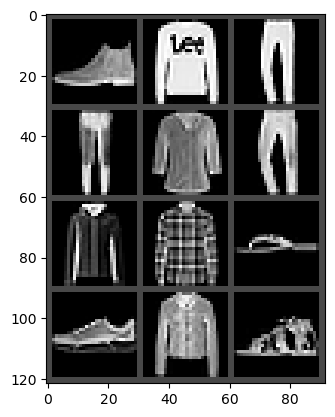

In [25]:
transform_test = transforms.Compose([
        # transforms.ToPILImage(),
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
# 加载测试集
with open('./attack_data/correct_1k.pkl', 'rb') as f:
    imgs, targets=pickle.load(f)
imgs = np.array(imgs) /255
targets = np.array(targets)
imgs = torch.from_numpy(imgs).view(1000, 1, 28, 28).float()
imgs = transform_test(imgs)
targets = torch.from_numpy(targets).view(1000).long()
test_data = torch.utils.data.TensorDataset(imgs, targets)
translator = torch.utils.data.DataLoader(test_data, batch_size=12, shuffle=False)

# 获取一个批次的图像数据
dataiter = iter(translator)
images, labels = dataiter.__next__()
%matplotlib inline
# 将图像拼接成一个网格
img_grid = torchvision.utils.make_grid(images, nrow=3)

# 将网格张量转换为 NumPy 数组，并交换通道的顺序
img_grid_np = img_grid.numpy().transpose((1, 2, 0)) * 0.3530 + 0.2860

# 显示图像
plt.imshow(img_grid_np, cmap='gray', clim=(0, 1))
plt.show()

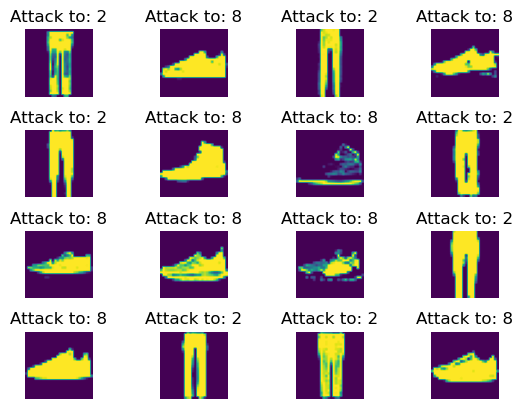

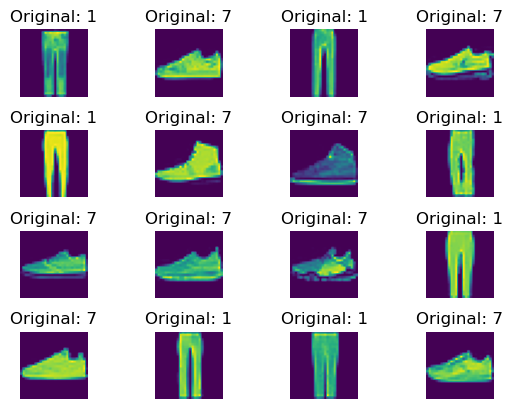

In [28]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 定义一个函数，将图像和标签网格化显示

def plot_images(images, isOriginal):
    # 创建一个 4x4 的图像网格
    fig, axes = plt.subplots(nrows=4, ncols=4)#, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    flag = np.zeros(10, dtype=bool)
    cnt = 0
    # 遍历 adv_examples 列表，将每个元素的图像和标签显示在对应的子图中
    for i, (data, perturbed_data, target) in enumerate(images):
        data = data.cpu().detach().numpy().squeeze()
        perturbed_data = perturbed_data.cpu().detach().numpy().squeeze()
        row = cnt // 4
        col = cnt % 4
        # if flag[target.item()]:
            # continue
        if isOriginal:
            ax = axes[row, col]
            # 将原始数据和扰动后的数据分别显示在同一个子图中
            ax.imshow(data)#, cmap='gray')
            ax.set_title(f'Original: {target.item()}')
            ax.axis('off')
            flag[target.item()] = True
            cnt += 1
        else:
            ax = axes[row, col]
            ax.imshow(perturbed_data)#, cmap='gray')
            ax.set_title(f'Attack to: {(target.item() + 1) % 10}')
            ax.axis('off')
            flag[target.item()] = True
            cnt += 1
        if cnt == 16:
            break
    plt.show()
adv_examples = torch.load('./attack_data/black/eps-0.002-ASR-0.150.pt')
# 调用 plot_images 函数，将 adv_examples 网格化显示
plot_images(adv_examples, False)

plot_images(adv_examples, True)



0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

0 T恤/上衣

1 裤子

2 套头衫

3 连衣裙

4 大衣

5 凉鞋

6 衬衫

7 运动鞋

8 袋子

9 低帮靴